# Predicting Soccer Matches

- To predict soccer matches seems like a very interesting problem on which to apply ML.  Soccer clubs, bettors, and others with a stake in the results are likewise looking to do so to gain an edge.

### Procedure
- The benchmarks will be 
    - ~50%, the accuracy rate at which most news outlets and pundits average
    - ~60%, an average of betting sites which use proprietary algorithms and methods
    - ~70%, the accuracy rate one would achieve if betting with the market
- Predictions will be of 'Team 1 Win', 'Team 2 Win', or 'Draw' between two sides, which makes this a classification problem
    - I hope to successfully apply and obtain serviceable results with one/some of Decision Trees, Random Forest, XGBoost, Support Vector Machines, and if time allows, a Dense Neural Network with a softmax output layer.

## Features

Apart from the basic statistics available in the datasets, existing formulas developed for sports prediction are incorporated as follows

**Form**

$$ \frac{1}{10} \sum_{k=1}^{5} result_k $$
where result_k = result of the –kth match (value of 0,1,2);

<br/>

**Concentration**

$$ 1 - 2x $$
where x is the distance to a match lost to a team in the bottom 1/3 of the rankings or of a ranking >20 below

<br/>

**Motivation**
$$ min(max( 1 - \frac{dist}{3 * left} , rivalry , \frac{stake + dist}{2} ), 1) $$
where
- rivalry: 1 if match is a rivalry, 0 otherwise
- dist - distance from Top 20 or Bottom 20
- left - games left to play at the moment (ie 3 if starting Group Stage, 0 if in elimination round)
- stake - 1 if game is in single elimination or for qualification <br/>
_okay this one is a little hard to implement, probably will leave it out for now_

<br/> <br/>


### To be included in a future update:
Paper by _Goven et. al_ posits that points scored by/against can be used proportionally to create Attack/Defense scores
http://meyer.math.ncsu.edu/Meyer/Talks/OD_RankingCharleston.pdf

**ODM Attack**
    $$ a_\text{team1} = \sum_{n=1}^{n} P_\text{t1t2} \frac{1}{d_\text{team1}} $$
    
**ODM Defense**
    $$ d_\text{team1} = \sum_{n=1}^{n} P_\text{t2t1} \frac{1}{a_\text{team1}} $$
    
P_t1t2_ being the points scored by team 1 on team 2. 
<br/>
P_t2t1_ being the reverse
<br/>
Since A & D are mutually dependent, compute as follows...


In [6]:
import pandas as pd
import numpy as np

In [88]:
# import rankings I scraped
rankings = pd.read_csv('./src/05052018rating_ensemble.csv')
rankings = rankings.drop('Unnamed: 0', axis=1)
rankings.head(5)

,dratings,fifaelo,thepowerrank,soccerway
0,Brazil,Germany,Germany,Germany
1,Germany,Brazil,Brazil,Brazil
2,France,Belgium,France,Belgium
3,Spain,Portugal,Argentina,Portugal
4,Belgium,Argentina,Spain,Argentina


In [30]:
tpr = list(rankings['thepowerrank'].values)

Ratings I collected from 4 different websites that have different methodologies for creating rankings

I don't know how to combine them, so I will use the ranking from https://thepowerrank.com 

In [89]:
# import dataset of international results with some columns I already added myself
results = pd.read_csv('./src/0505results.csv')
results = results.drop('Unnamed: 0', axis=1)
results.head(5)

,date,home_team,away_team,home_score,away_score,tournament,neutral,draw,home_win,margin_win,away_win
0,1938-01-09,Dominica,St. Lucia,4,1,Friendly,False,False,True,3,False
1,1938-01-09,Portugal,Hungary,4,0,Friendly,False,False,True,4,False
2,1938-01-10,Dominica,St. Lucia,1,3,Friendly,False,False,False,-2,True
3,1938-01-11,Dominica,St. Lucia,1,0,Friendly,False,False,True,1,False
4,1938-01-16,Luxembourg,Hungary,0,6,Friendly,False,False,False,-6,True


This dataset from Kaggle goes back to 1872. But I will only take the rows starting from the year 2010 so that the rankings are still somewhat applicable

In [14]:
results[ results['date'].str.contains('2010') ].head(1)

,date,home_team,away_team,home_score,away_score,tournament,neutral,draw,home_win,margin_win,away_win
29403,2010-01-02,Iran,Korea DPR,1,0,Friendly,True,False,True,1,False


In [90]:
results = results[ 29403: ]

In [91]:
results.shape

(7518, 11)

Still have 7518 columns to use

In [17]:
homeset =  set( results['home_team'].values  )

In [18]:
m = []
for i in tpr:
    if i not in homeset:
        m.append([ i, tpr.index(i)])

In [20]:
len(tpr)

207

In [31]:
top_teams = tpr[:30]
bottom_teams = tpr[-30:]

In [21]:
rankings = pd.read_csv('./src/newrank.csv')

In [22]:
def return_rank(team):
    try:
        tpr.index(team)
    except:
        return 200
    else:
        return tpr.index(team) + 1

In [23]:
results['away_rank'] = results['away_team'].apply(return_rank)
results['home_rank'] = results['home_team'].apply(return_rank)

In [24]:
results = results.reset_index(drop=True)
results.head()

,date,home_team,away_team,home_score,away_score,tournament,neutral,draw,home_win,margin_win,away_win,away_rank,home_rank
0,2010-01-02,Iran,Korea DPR,1,0,Friendly,True,False,True,1,False,129,45
1,2010-01-02,Qatar,Mali,0,0,Friendly,False,True,False,0,False,64,81
2,2010-01-02,Syria,Zimbabwe,6,0,Friendly,True,False,True,6,False,70,89
3,2010-01-02,Yemen,Tajikistan,0,1,Friendly,False,False,False,-1,True,164,155
4,2010-01-03,Angola,Gambia,1,1,Friendly,True,True,False,0,False,130,104


In [25]:
reverse_results = results.copy()
reverse_results = reverse_results.iloc[::-1]
reverse_results = reverse_results.reset_index(drop=True)
reverse_results.head()

,date,home_team,away_team,home_score,away_score,tournament,neutral,draw,home_win,margin_win,away_win,away_rank,home_rank
0,2018-04-30,Antigua and Barbuda,Jamaica,0,2,Friendly,False,False,False,-2,True,69,142
1,2018-04-26,St. Kitts and Nevis,Jamaica,1,3,Friendly,False,False,False,-2,True,69,144
2,2018-04-18,Zimbabwe,Botswana,0,1,Friendly,False,False,False,-1,True,102,70
3,2018-04-18,Trinidad and Tobago,Panama,0,1,Friendly,False,False,False,-1,True,60,91
4,2018-04-01,Malaysia,Bhutan,7,0,Friendly,False,False,True,7,False,203,179


In [26]:
home_hist = list(reverse_results['home_team'].values)
away_hist = list(reverse_results['away_team'].values)

In [27]:
def search(team, array):
    return array.index(team)

In [33]:
def get_con(team):
    last_away = search(team, away_hist)
    last_home = search(team, home_hist)
    
    awayopp_bottom = reverse_results.iloc[last_away]['home_team'] in bottom_teams is True
    homeopp_bottom = reverse_results.iloc[last_home]['away_team'] in bottom_teams is True
    
    # print('bottom', awayopp_bottom, homeopp_bottom)
    
    away_bigdiff = reverse_results.iloc[last_away]['away_rank'] - reverse_results.iloc[last_away]['home_rank'] > 10
    home_bigdiff = reverse_results.iloc[last_home]['home_rank'] - reverse_results.iloc[last_home]['away_rank'] > 10
    
    # print('diff', away_bigdiff, home_bigdiff)
    
    if reverse_results.iloc[last_away]['away_win'] is False:
        if awayopp_bottom or away_bigdiff:
            away_con = ( 1 - 2( last_away ) )
        else: 
            away_con = 0
    else:
        away_con = 0
        
    
    if reverse_results.iloc[last_home]['home_win'] is False:
        if homeopp_bottom or home_bigdiff :
            home_con = ( 1 - 2( home_away ) )
        else: 
            home_con = 0
    else:
        home_con = 0
        
    if away_con > home_con:
        return away_con
    else:
        return home_con

In [35]:
for i,v in enumerate(reverse_results.columns):
    print(i,v)

0 date
1 home_team
2 away_team
3 home_score
4 away_score
5 tournament
6 neutral
7 draw
8 home_win
9 margin_win
10 away_win
11 away_rank
12 home_rank


In [36]:
def get_form(team):
    afilter = reverse_results['away_team'].str.contains(team)
    hfilter = reverse_results['home_team'].str.contains(team)
    
    hist = reverse_results[ afilter | hfilter ].head()
    
    flist = []
    
    for row in hist.values:
        if row[1] == team:
            if row[8]:
                flist.append(2)
            elif not row[8] and row[7]:
                flist.append(1)
            else:
                flist.append(0)
        else:
            if row[10]:
                flist.append(2)
            elif not row[10] and row[7]:
                flist.append(1)
            else:
                flist.append(0)
                
    return 0.1 * sum(flist)

In [37]:
results['home_form'] = results['home_team'].apply(get_form)
results['away_form'] = results['away_team'].apply(get_form)

In [38]:
results.head()

,date,home_team,away_team,home_score,away_score,tournament,neutral,draw,home_win,margin_win,away_win,away_rank,home_rank,home_form,away_form
0,2010-01-02,Iran,Korea DPR,1,0,Friendly,True,False,True,1,False,129,45,0.8,0.5
1,2010-01-02,Qatar,Mali,0,0,Friendly,False,True,False,0,False,64,81,0.6,0.4
2,2010-01-02,Syria,Zimbabwe,6,0,Friendly,True,False,True,6,False,70,89,0.4,0.4
3,2010-01-02,Yemen,Tajikistan,0,1,Friendly,False,False,False,-1,True,164,155,0.3,0.5
4,2010-01-03,Angola,Gambia,1,1,Friendly,True,True,False,0,False,130,104,0.6,0.6


In [39]:
rankings.columns

Index(['Unnamed: 0', 'dratings', 'fifaelo', 'thepowerrank', 'soccerway'], dtype='object')

In [40]:
def extend_rank(team, arr):
    try:
        arr.index(team)
    except:
        return np.NaN
    else:
        return arr.index(team) + 1

In [41]:
dr = list(rankings['dratings'].values)
fe = list(rankings['fifaelo'].values)
sw = list(rankings['soccerway'].values)

In [42]:
results['away_rankdr'] = [ extend_rank(x, dr) for x in results['away_team'] ]
results['home_rankdr'] = [ extend_rank(x, dr) for x in results['home_team'] ]
results['away_rankfe'] = [ extend_rank(x, fe) for x in results['away_team'] ]
results['home_rankfe'] = [ extend_rank(x, fe) for x in results['home_team'] ]
results['away_ranksw'] = [ extend_rank(x, sw) for x in results['away_team'] ]
results['home_ranksw'] = [ extend_rank(x, sw) for x in results['home_team'] ]

In [43]:
results.head()

,date,home_team,away_team,home_score,away_score,tournament,neutral,draw,home_win,margin_win,...,away_rank,home_rank,home_form,away_form,away_rankdr,home_rankdr,away_rankfe,home_rankfe,away_ranksw,home_ranksw
0,2010-01-02,Iran,Korea DPR,1,0,Friendly,True,False,True,1,...,129,45,0.8,0.5,NaN,31.0,112.0,NaN,112.0,36.0
1,2010-01-02,Qatar,Mali,0,0,Friendly,False,True,False,0,...,64,81,0.6,0.4,83.0,81.0,67.0,101.0,67.0,101.0
2,2010-01-02,Syria,Zimbabwe,6,0,Friendly,True,False,True,6,...,70,89,0.4,0.4,80.0,67.0,110.0,76.0,110.0,76.0
3,2010-01-02,Yemen,Tajikistan,0,1,Friendly,False,False,False,-1,...,164,155,0.3,0.5,156.0,157.0,118.0,125.0,118.0,125.0
4,2010-01-03,Angola,Gambia,1,1,Friendly,True,True,False,0,...,130,104,0.6,0.6,148.0,102.0,175.0,138.0,175.0,138.0


In [44]:
results['draw'] = results.apply(lambda row: row.home_score == row.away_score, axis=1)
results['home_win'] = results.apply(lambda row: row.home_score > row.away_score, axis=1)

In [45]:
def winny(row):
    if row['draw']:
        return 0
    elif row['home_win']:
        return 1
    else:
        return 2

In [46]:
results['winner'] = results.apply(lambda row: winny(row), axis=1)

In [47]:
results.head()

,date,home_team,away_team,home_score,away_score,tournament,neutral,draw,home_win,margin_win,...,home_rank,home_form,away_form,away_rankdr,home_rankdr,away_rankfe,home_rankfe,away_ranksw,home_ranksw,winner
0,2010-01-02,Iran,Korea DPR,1,0,Friendly,True,False,True,1,...,45,0.8,0.5,NaN,31.0,112.0,NaN,112.0,36.0,1
1,2010-01-02,Qatar,Mali,0,0,Friendly,False,True,False,0,...,81,0.6,0.4,83.0,81.0,67.0,101.0,67.0,101.0,0
2,2010-01-02,Syria,Zimbabwe,6,0,Friendly,True,False,True,6,...,89,0.4,0.4,80.0,67.0,110.0,76.0,110.0,76.0,1
3,2010-01-02,Yemen,Tajikistan,0,1,Friendly,False,False,False,-1,...,155,0.3,0.5,156.0,157.0,118.0,125.0,118.0,125.0,2
4,2010-01-03,Angola,Gambia,1,1,Friendly,True,True,False,0,...,104,0.6,0.6,148.0,102.0,175.0,138.0,175.0,138.0,0


In [48]:
results.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'neutral', 'draw', 'home_win', 'margin_win', 'away_win',
       'away_rank', 'home_rank', 'home_form', 'away_form', 'away_rankdr',
       'home_rankdr', 'away_rankfe', 'home_rankfe', 'away_ranksw',
       'home_ranksw', 'winner'],
      dtype='object')

In [49]:
final = results.copy()
final = final[['away_rank', 'home_rank', 'home_form', 'away_form', 'away_rankdr',
       'home_rankdr', 'away_rankfe', 'home_rankfe', 'away_ranksw',
       'home_ranksw', 'winner']]
final = final.dropna()
final.isnull().sum()

away_rank      0
home_rank      0
home_form      0
away_form      0
away_rankdr    0
home_rankdr    0
away_rankfe    0
home_rankfe    0
away_ranksw    0
home_ranksw    0
winner         0
dtype: int64

In [50]:
X = final[[ 'away_rank', 'home_rank', 'home_form', 'away_form', 'away_rankdr',
       'home_rankdr', 'away_rankfe', 'home_rankfe', 'away_ranksw',
       'home_ranksw']]
Y = final['winner']

In [51]:
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
% matplotlib inline
% config InlineBackend.figure_format = 'retina'

import seaborn as sns

from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

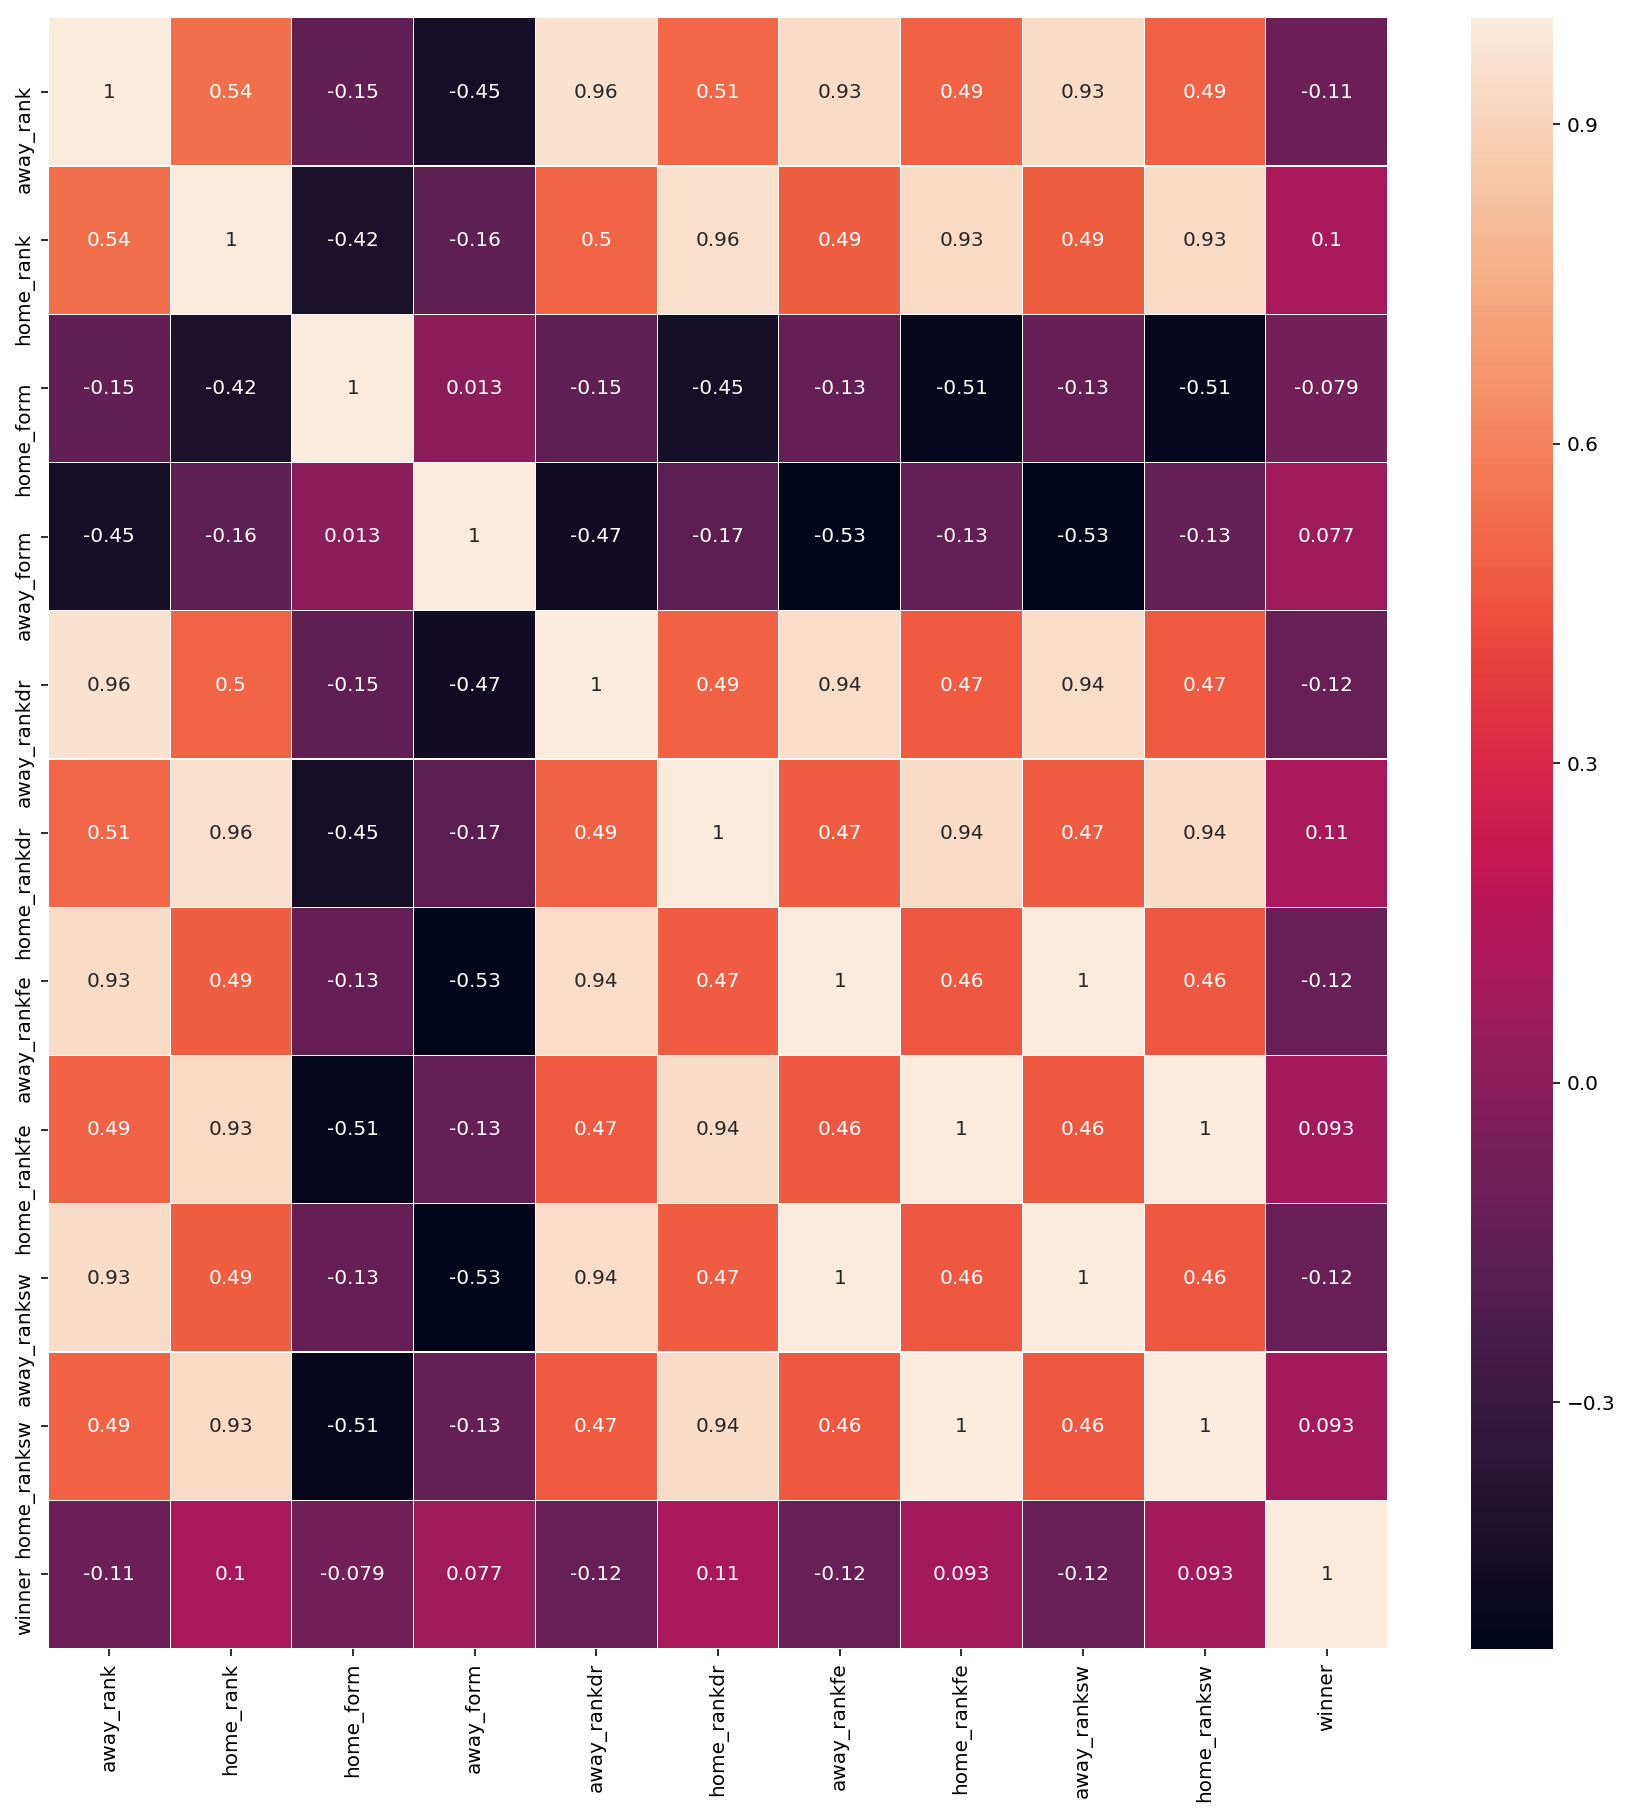

In [52]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(final.corr(), annot=True, linewidths=0.1, linecolor='white', cbar=True)

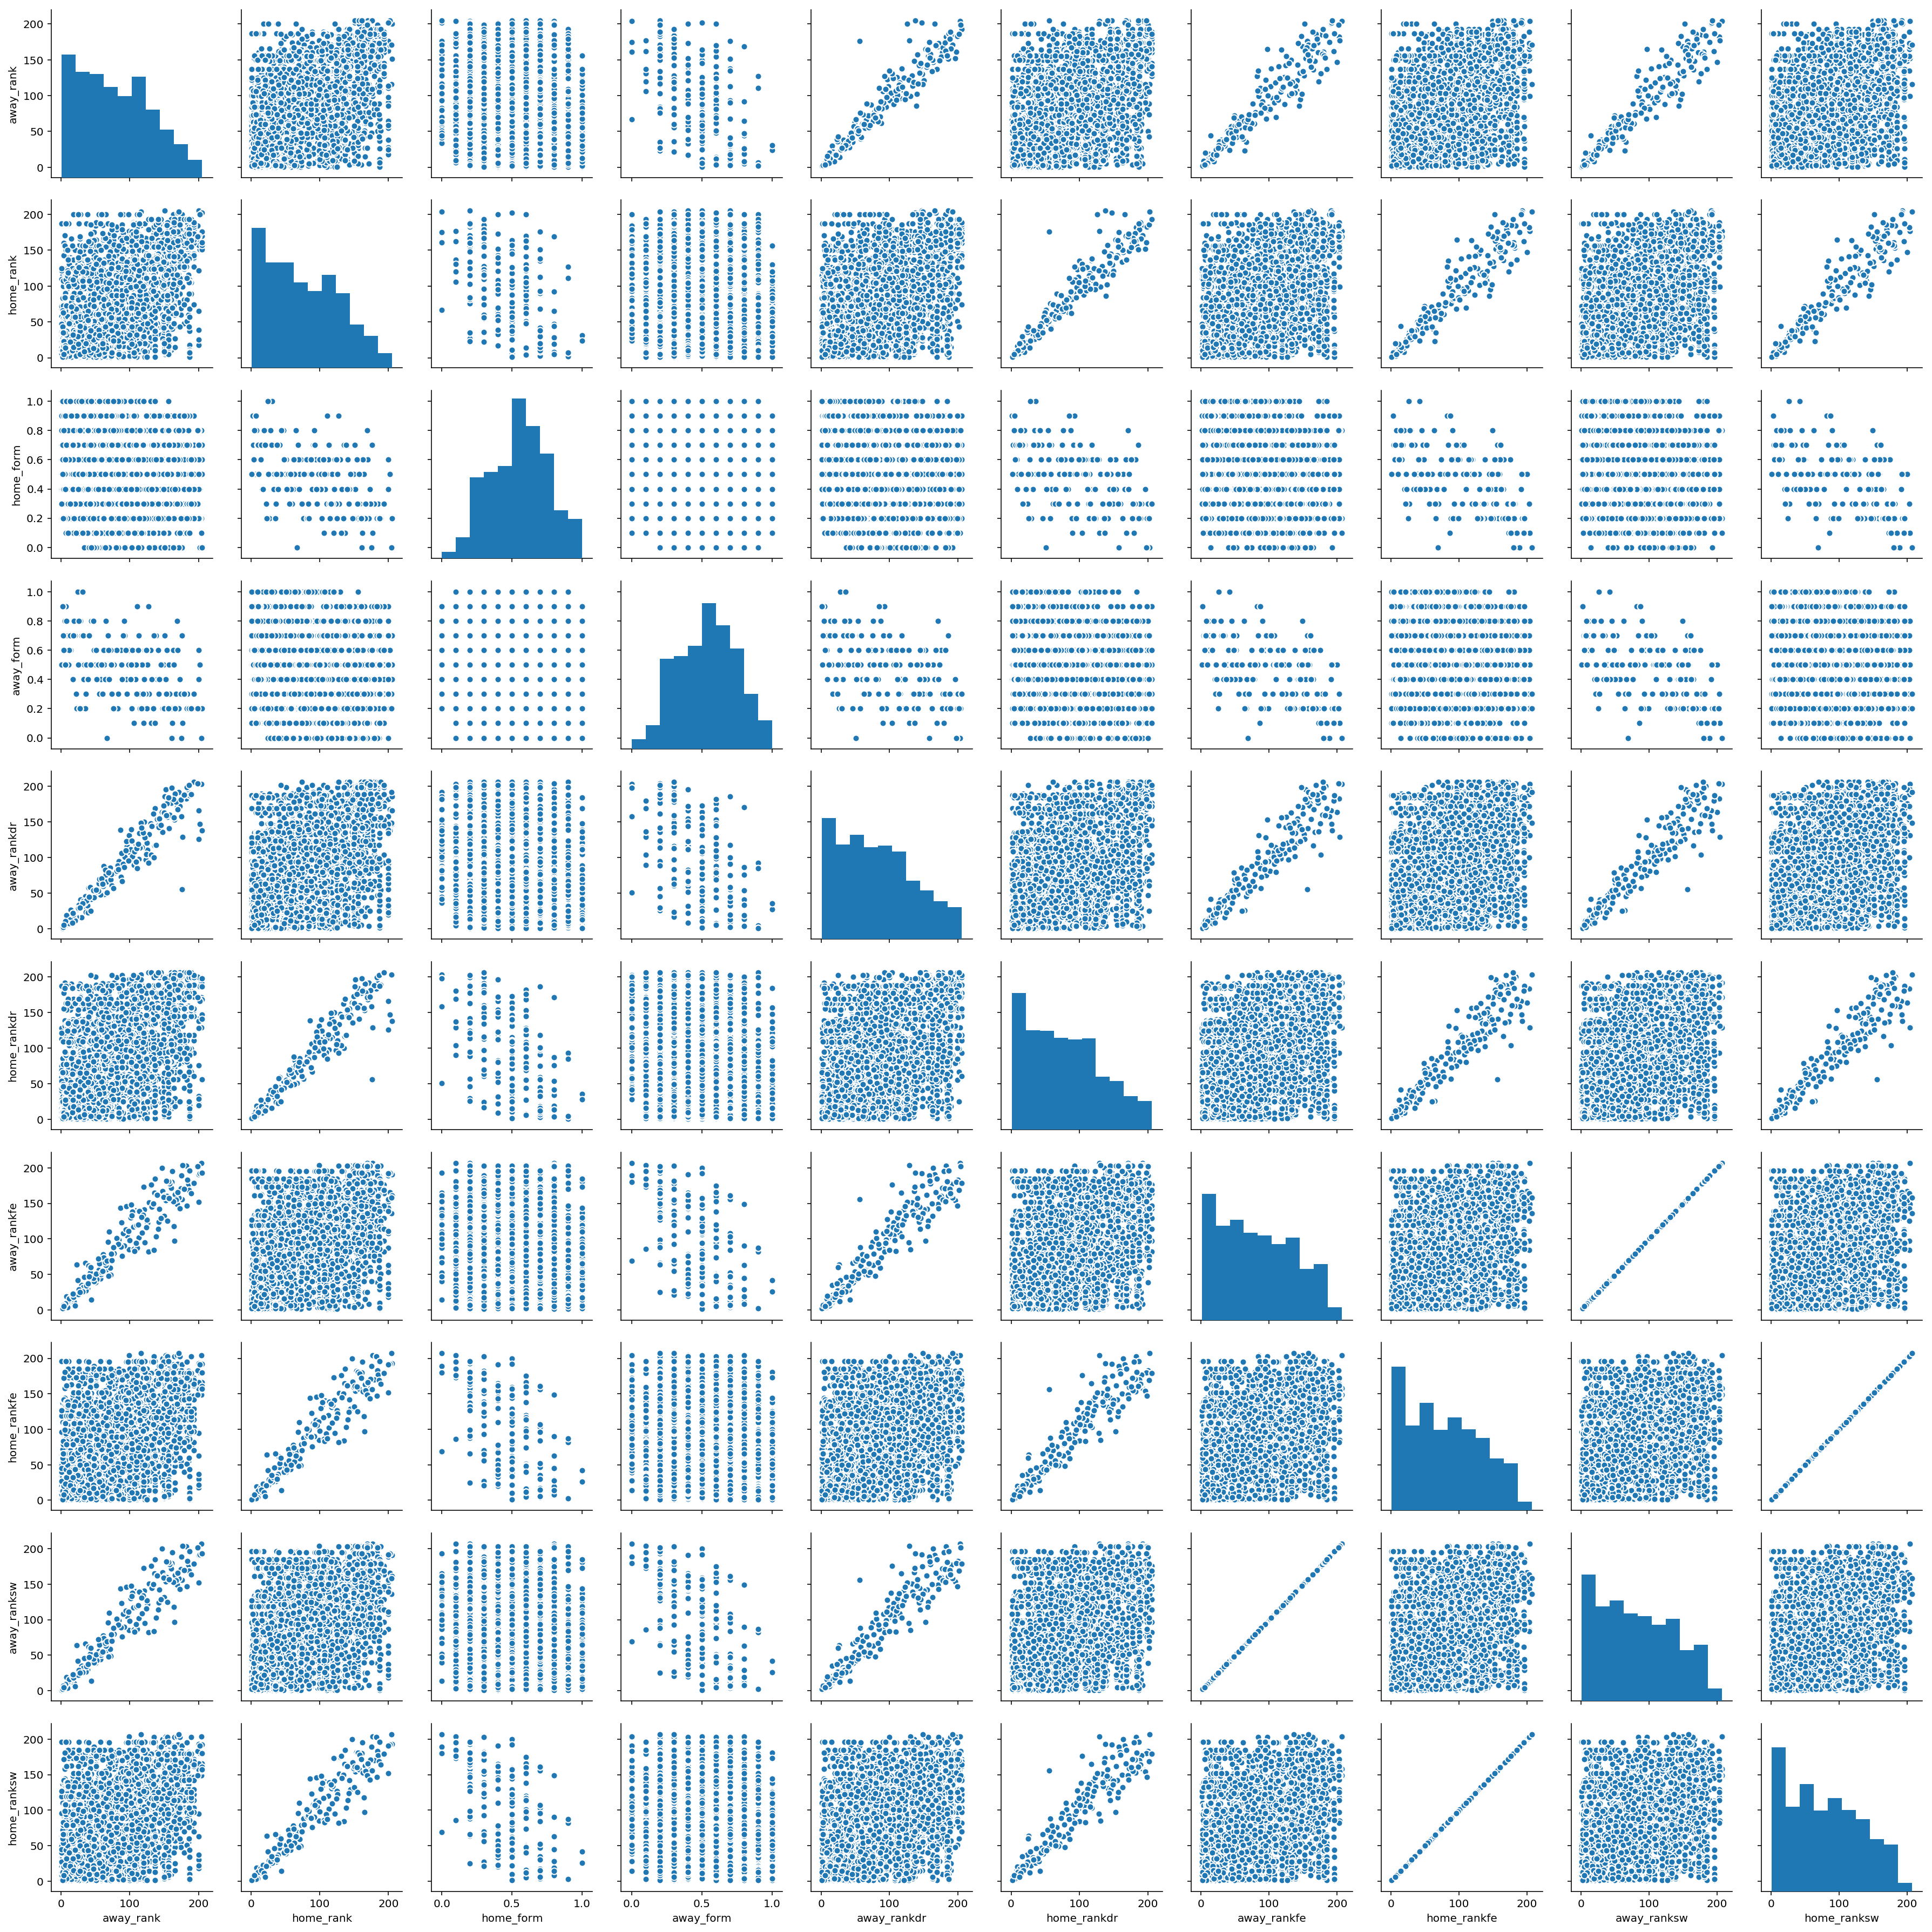

In [53]:
sns.pairplot(X)

In [54]:
clf = svm.SVC(kernel='rbf')
knn = KNeighborsClassifier(n_neighbors=2)

# Test / Train Split

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

# Cross Validation

In [65]:
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [104]:
models = []
seed = 8
scoring = 'accuracy'
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.564276 (0.029657)
KNN: 0.491225 (0.028002)
CART: 0.452728 (0.021024)
NB: 0.537575 (0.017344)
SVM: 0.457186 (0.022600)


# KNN Training

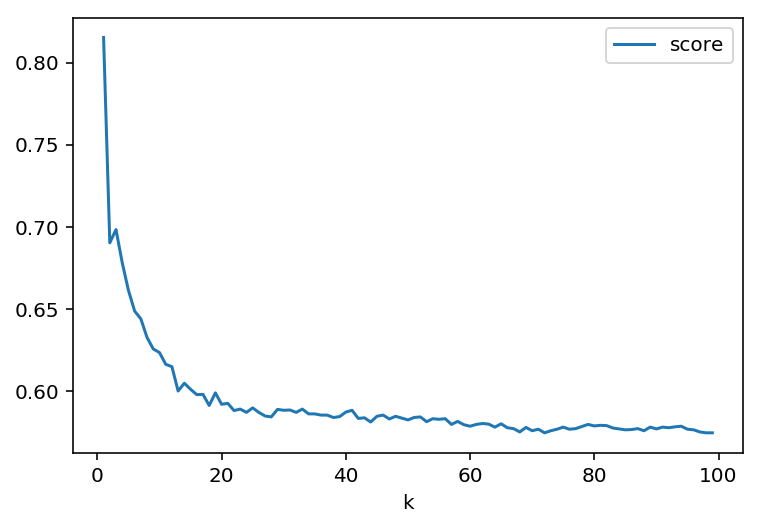

In [58]:
scores = []
for k in range(1,100):
    kna = KNeighborsClassifier(n_neighbors=k)
    kna.fit(X,Y)
    pred = kna.predict(X)
    score = float(sum(pred == Y)) / len(Y)
    scores.append([k, score])
nata = pd.DataFrame(scores,columns=['k','score'])
nata.plot.line(x='k',y='score')

In [59]:
nata.sort_values('score', ascending=True).head()

,k,score
98,99,0.574413
71,72,0.574413
97,98,0.574413
67,68,0.574963
96,97,0.574963


## Tuned KNN results in 57.4% accuracy

---
# SVM Training

In [60]:
from sklearn import grid_search
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_searcha = grid_search.GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_searcha.fit(X, y)
    return grid_searcha.best_params_

/Users/William/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/William/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [61]:
svc_param_selection(X,Y,10)

{'C': 1, 'gamma': 0.001}

In [62]:
svm.SVC?

In [63]:
clf = svm.SVC(kernel='rbf', C=1, gamma=0.001)

In [64]:
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
print((accuracy_score(Y_test, y_pred)))

0.5644471594379963


## SVM Tuned with Grid Search results in 56.4% accuracy

---

Add year


In [75]:
final.head()

,away_rank,home_rank,home_form,away_form,away_rankdr,home_rankdr,away_rankfe,home_rankfe,away_ranksw,home_ranksw,winner
1,64,81,0.6,0.4,83.0,81.0,67.0,101.0,67.0,101.0,0
2,70,89,0.4,0.4,80.0,67.0,110.0,76.0,110.0,76.0,1
3,164,155,0.3,0.5,156.0,157.0,118.0,125.0,118.0,125.0,2
4,130,104,0.6,0.6,148.0,102.0,175.0,138.0,175.0,138.0,0
5,64,34,0.5,0.4,83.0,37.0,67.0,46.0,67.0,46.0,1


In [96]:
finaltwo = results.copy()
finaltwo = finaltwo.reset_index(drop=True)
finaltwo.head()

,date,home_team,away_team,home_score,away_score,tournament,neutral,draw,home_win,margin_win,away_win
0,2010-01-02,Iran,Korea DPR,1,0,Friendly,True,False,True,1,False
1,2010-01-02,Qatar,Mali,0,0,Friendly,False,True,False,0,False
2,2010-01-02,Syria,Zimbabwe,6,0,Friendly,True,False,True,6,False
3,2010-01-02,Yemen,Tajikistan,0,1,Friendly,False,False,False,-1,True
4,2010-01-03,Angola,Gambia,1,1,Friendly,True,True,False,0,False


In [97]:
int(finaltwo.loc[0].date[:4])

2010

In [98]:
final['year'] = finaltwo['date'].apply( lambda x: int(x[:4])  )

In [99]:
final.head()

,away_rank,home_rank,home_form,away_form,away_rankdr,home_rankdr,away_rankfe,home_rankfe,away_ranksw,home_ranksw,winner,year
1,64,81,0.6,0.4,83.0,81.0,67.0,101.0,67.0,101.0,0,2010
2,70,89,0.4,0.4,80.0,67.0,110.0,76.0,110.0,76.0,1,2010
3,164,155,0.3,0.5,156.0,157.0,118.0,125.0,118.0,125.0,2,2010
4,130,104,0.6,0.6,148.0,102.0,175.0,138.0,175.0,138.0,0,2010
5,64,34,0.5,0.4,83.0,37.0,67.0,46.0,67.0,46.0,1,2010


In [100]:
W = final[[ 'away_rank', 'home_rank', 'home_form', 'away_form', 'away_rankdr',
       'home_rankdr', 'away_rankfe', 'home_rankfe', 'away_ranksw',
       'home_ranksw', 'year']]
Z = final['winner']

In [105]:
S = final[[ 'away_rank', 'home_rank', 'home_form', 'away_form', 'year']]
R = final['winner']

In [101]:
W_train, W_test, Z_train, Z_test = train_test_split(W, Z, test_size=0.3)
S_train, S_test, R_train, Z_test = train_test_split(W, Z, test_size=0.3)

In [ ]:
models = []
seed = 8
scoring = 'accuracy'
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

In [103]:
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

models = []
seed = 8
scoring = 'accuracy'
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.564276 (0.029657)
KNN: 0.491225 (0.028002)
CART: 0.454303 (0.015797)
NB: 0.537575 (0.017344)
SVM: 0.457186 (0.022600)
